# Ideas for SSI policy research

Use existing datasets of software mentions in publications or preprints to analyse aspects of how research software projects have changed over time, or differ between disciplines.

Input datasources:
- CZI Software Mentions (includes extracted github links)
- Softcite Software Mentions (doesn’t include github links) 
- crawl ePrints to extract github links and associate with appropriate metadata, to create an equivalent set

Potential questions:
- How has preferred license changed over time?
- How has team size (number of concurrent contributors?) changed over time?
- How has commit frequency changed over time?
- How has linkage to other research outputs (e.g. DOIs to datasets, papers being included in READMEs) changed over time?
- License in context of topic (keywords etc)

## How to run this notebook

Install the following additional requirements in your environment:

- [PyGithub](https://pygithub.readthedocs.io/en/latest/)
- [tqdm](https://github.com/tqdm/tqdm#installation)
- [matplortlib](https://matplotlib.org/stable/users/getting_started/index.html)

Download the [CZI dataset](https://datadryad.org/stash/dataset/doi:10.5061/dryad.6wwpzgn2c) and place it in the root of this repository, in a folder called `data`.

In order not to run into the GitHub API requests limit immediately, [create an access token (classic)](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token#creating-a-personal-access-token-classic). Then, create a file called `config.cfg` at the root of this repository, with the following content:

```bash
[ACCESS]
token = <your-access-token>
```

You should be all set up now and able to run the code below.

In [1]:
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', 1000)

In [2]:
import requests
from github import Github
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
ROOT_DATA_DIR = '../data/'

In [11]:
# Get Config
import configparser
import os
#print(os.getcwd())

config = configparser.ConfigParser()
config.read('../config.cfg')
config.sections()

access_token = config['ACCESS']['token']

## Dataset: GitHub linked software

Concentrating on software linked on GitHub for now.

In [16]:
# read in data file from extracted files
linked_df = pd.read_csv(
    ROOT_DATA_DIR + 'linked/metadata.tsv.gz', 
    sep = '\\t', 
    engine = 'python', 
    compression = 'gzip', 
    on_bad_lines = 'warn')  # changed from deprecated error_bad_lines to on_bad_lines, but using 'warn' instead of 'skip' to find how many issues there are

# view first 5 lines to check import has worked 
linked_df.head()

Skipping line 79480: Expected 16 fields in line 79480, saw 17. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


,ID,software_mention,mapped_to,source,platform,package_url,description,homepage_url,other_urls,license,github_repo,github_repo_license,exact_match,RRID,reference,scicrunch_synonyms
0,SM5081,0,0,Pypi Index,Pypi,https://pypi.org/project/0,0,[None],NaN,OSI Approved :: MIT License,[None],NaN,True,None,None,None
1,SM64750,1,1,Pypi Index,Pypi,https://pypi.org/project/1,test,[None],NaN,NaN,[None],NaN,True,None,None,None
2,SM1007758,1024,1024,Pypi Index,Pypi,https://pypi.org/project/1024,NaN,[None],NaN,NaN,[None],NaN,True,None,None,None
3,SM288357,16,16,Pypi Index,Pypi,https://pypi.org/project/16,NaN,[None],NaN,NaN,[None],NaN,True,None,None,None
4,SM349537,1st,1st,Pypi Index,Pypi,https://pypi.org/project/1st,NaN,[None],NaN,NaN,[None],NaN,True,None,None,None


In [17]:
github_df = linked_df[linked_df['source'] == 'Github API']
len(github_df) 
# 112708 rows  

112708

In [18]:
def parse_github_repo_url(url: str):
    try:
        _,_,_,user,repo_name = url.split('/')
    except ValueError:
        print(f"Could not unpack URL {url} into 5 segments. Refactor function parse_github_repo.")
    return user, repo_name

## GitHub API

In [19]:
test_data = github_df.sample(1)
test_url = test_data.github_repo.values[0]

In [20]:
test_data

,ID,software_mention,mapped_to,source,platform,package_url,description,homepage_url,other_urls,license,github_repo,github_repo_license,exact_match,RRID,reference,scicrunch_synonyms
131074,SM544636,ATPM,ATPM,Github API,NaN,https://github.com/Yerfin/ATPM,NaN,NaN,NaN,NaN,https://github.com/Yerfin/ATPM,NaN,True,None,None,None


In [21]:
test_user, test_repo_name = parse_github_repo_url(test_url)

In [22]:
repo_data = requests.get(f'https://api.github.com/repos/{test_user}/{test_repo_name}').json()
repo_data

{'id': 180456328,
 'node_id': 'MDEwOlJlcG9zaXRvcnkxODA0NTYzMjg=',
 'name': 'ATPM',
 'full_name': 'Yerfin/ATPM',
 'private': False,
 'owner': {'login': 'Yerfin',
  'id': 49458563,
  'node_id': 'MDQ6VXNlcjQ5NDU4NTYz',
  'avatar_url': 'https://avatars.githubusercontent.com/u/49458563?v=4',
  'gravatar_id': '',
  'url': 'https://api.github.com/users/Yerfin',
  'html_url': 'https://github.com/Yerfin',
  'followers_url': 'https://api.github.com/users/Yerfin/followers',
  'following_url': 'https://api.github.com/users/Yerfin/following{/other_user}',
  'gists_url': 'https://api.github.com/users/Yerfin/gists{/gist_id}',
  'starred_url': 'https://api.github.com/users/Yerfin/starred{/owner}{/repo}',
  'subscriptions_url': 'https://api.github.com/users/Yerfin/subscriptions',
  'organizations_url': 'https://api.github.com/users/Yerfin/orgs',
  'repos_url': 'https://api.github.com/users/Yerfin/repos',
  'events_url': 'https://api.github.com/users/Yerfin/events{/privacy}',
  'received_events_url': 'h

In [23]:
g = Github()
test_repo = g.get_repo(f'{test_user}/{test_repo_name}')

In [24]:
for s in test_repo.get_stats_contributors():
    print(s.author)
    for w in s.weeks:
        if w.a > 0 or w.d > 0 or w.c > 0:
            print(f"Contribution in week {w.w}: Additions {w.a}, Deletions {w.d}, Commits {w.c}")
# currently throws error: TypeError: 'NoneType' object is not iterable

TypeError: 'NoneType' object is not iterable

In [25]:
github_df.columns

Index(['ID', 'software_mention', 'mapped_to', 'source', 'platform',
       'package_url', 'description', 'homepage_url', 'other_urls', 'license',
       'github_repo', 'github_repo_license', 'exact_match', 'RRID',
       'reference', 'scicrunch_synonyms'],
      dtype='object')

In [26]:
github_df[:10]

,ID,software_mention,mapped_to,source,platform,package_url,description,homepage_url,other_urls,license,github_repo,github_repo_license,exact_match,RRID,reference,scicrunch_synonyms
59868,SM900,XDS,XDS,Github API,NaN,https://github.com/ichfly/XDS,NaN,NaN,NaN,NaN,https://github.com/ichfly/XDS,GPL-2.0,True,None,None,None
59869,SM910,MR,MR,Github API,NaN,https://github.com/bkerler/MR,Mobile Revelator,NaN,NaN,NaN,https://github.com/bkerler/MR,MIT,True,None,None,None
59870,SM922,CCP4,CCP4,Github API,NaN,https://github.com/DhanashriShanbhag/CCP4,NaN,NaN,NaN,NaN,https://github.com/DhanashriShanbhag/CCP4,NaN,True,None,None,None
59871,SM932,RESOLVE,RESOLVE,Github API,NaN,https://github.com/ClemsonRSRG/RESOLVE,RESOLVE (REusable SOftware Language with VErification) is a specification and programming language designed for verifying correctness of object oriented programs.,NaN,NaN,NaN,https://github.com/ClemsonRSRG/RESOLVE,BSD-3-Clause,True,None,None,None
59872,SM947,COOT,COOT,Github API,NaN,https://github.com/PythonOT/COOT,CO-Optimal Transport,NaN,NaN,NaN,https://github.com/PythonOT/COOT,MIT,True,None,None,None
59873,SM954,iSee,iSee,Github API,NaN,https://github.com/DanielKoehler/iSee,"iOS, OpenCV, Eye Tracking, NHS Hack Day Cardiff",NaN,NaN,NaN,https://github.com/DanielKoehler/iSee,NaN,True,None,None,None
59874,SM961,dxTuber,dxTuber,Github API,NaN,https://github.com/willhelm-mueller/dxTuber,NaN,NaN,NaN,NaN,https://github.com/willhelm-mueller/dxTuber,NaN,True,None,None,None
59875,SM968,NESG,NESG,Github API,NaN,https://github.com/francisatoyebi/NESG,"A volunteer job done with a team. Analysing Nigeria's historical data, coming up with insights and recommendations for the Nigerian government based on Economic growth.",NaN,NaN,NaN,https://github.com/francisatoyebi/NESG,NaN,True,None,None,None
59876,SM976,CELLO,CELLO,Github API,NaN,https://github.com/WangLabHKUST/CELLO,[source] CELLO - Cancer EvoLution toolbox for LOngitudinal data,NaN,NaN,NaN,https://github.com/WangLabHKUST/CELLO,NaN,True,None,None,None
59877,SM982,Qualitek,Qualitek,Github API,NaN,https://github.com/jeffwangsoftware/Qualitek,Mobile App Dev,NaN,NaN,NaN,https://github.com/jeffwangsoftware/Qualitek,NaN,True,None,None,None


## Dataset: Curated Links

Think only the mentions themselves are curated (software, not software, unclear), not the links.
Actually not true: biocurators get 50 mentions with the generated links. (136 mentions in total as they have multiple mentions)

- 54% correct
- 6% incorrect
- 40% unclear
  - 39/40 from GitHub, one from PyPI
- stuff linked through PyPI, Bioconductor, CRAN, SciCrunch had much higher accuracy

In [28]:
evaluation_linked = pd.read_csv(ROOT_DATA_DIR + 'evaluation/evaluation_linking.csv')

In [29]:
evaluation_linked.columns

Index(['location', 'pmcid', 'pmid', 'doi', 'pubdate', 'source', 'number',
       'text', 'software_mention', 'version', 'mapped_to',
       'package_url_source', 'package_url', 'description', 'homepage_url',
       'other_urls', 'package_license', 'github_repo', 'exact_match', 'RRID',
       'reference', 'scicrunch_synonyms', 'link_label'],
      dtype='object')

In [30]:
evaluation_linked.groupby(['package_url_source', 'link_label'])['link_label'].count()

package_url_source  link_label
CRAN Index          correct        9
Github API          correct       77
                    incorrect      7
                    unclear       52
Pypi Index          unclear        1
SciCrunch API       correct        5
Name: link_label, dtype: int64

## Crawl

Use GitHub API to query contributions and contents of linked GitHub Repos. In this case only considering curated set.

In [31]:
g = Github(access_token)

In [32]:
def crawl_repo(df):
    """For all github repositories in dataset, retrieve contributions, contents.

    Args:
        df (pd.DataFrame): CZI linked dataset with links to GitHub

    Returns:
        (pd.DataFrame, pd.DataFrame): one data frame holding info on contributions, one data frame holding info on licenses.
            - contributions dataframe columns:
                - github_repo: same as in CZI linked dataset
                - author: contributor to repository
                - year, week: determine the week of contributions in question
                - commits: number of commits in that specific week
            - license dataframe columns:
                - github_repo: same as in CZI linked dataset
                - license: license key if license was found (e.g. mit, lgpl-3.0, mpl-2.0, ... (https://docs.github.com/en/rest/licenses?apiVersion=2022-11-28#get-all-commonly-used-licenses))
                - readme_size: size of README file, 0 if none was found
    """
    contributions_df = pd.DataFrame(columns=['github_repo', 'author', 'year', 'week', 'commits'])
    contents_df = pd.DataFrame(columns=['github_repo', 'license', 'readme_size'])
    for u in tqdm(df['github_repo']):
        user, repo_name = parse_github_repo_url(u)
        try:
            repo = g.get_repo(f"{user}/{repo_name}")
        except:
            print(f"Could not resolve repository for URL {u}.")
        contribution_stats = repo.get_stats_contributors()
        if contribution_stats is not None:
            for s in contribution_stats:
                for w in s.weeks:
                    contributions_df.loc[len(contributions_df)] = [u, s.author, w.w.year, w.w.isocalendar().week, w.c]
        try:
            license_file = repo.get_license()
            license_entry = license_file.license.key
        except:
            license_entry = None
        try:
            readme = repo.get_readme()
            readme_entry = readme.size
        except:
            readme_entry = 0
        contents_df.loc[len(contents_df)] = [u, license_entry, readme_entry]
    return contributions_df, contents_df

In [33]:
contributions_df, contents_df = crawl_repo(evaluation_linked[evaluation_linked['package_url_source'] == 'Github API'])
contributions_df.to_csv(ROOT_DATA_DIR + f'evaluation/contributions.tsv.gz', sep="\t", index = False, compression = 'gzip')
contents_df.to_csv(ROOT_DATA_DIR + f'evaluation/contents.tsv.gz', sep="\t", index = False, compression = 'gzip')

 26%|████████████████▋                                              | 36/136 [02:31<06:34,  3.94s/it]

Could not resolve repository for URL https://github.com/HongjianLi/idock.


 27%|█████████████████▏                                             | 37/136 [02:40<08:53,  5.39s/it]

Could not resolve repository for URL https://github.com/HongjianLi/idock.


 28%|█████████████████▌                                             | 38/136 [02:42<07:09,  4.38s/it]

Could not resolve repository for URL https://github.com/HongjianLi/idock.


 29%|██████████████████                                             | 39/136 [02:46<07:04,  4.38s/it]

Could not resolve repository for URL https://github.com/HongjianLi/idock.


 29%|██████████████████▌                                            | 40/136 [02:48<05:54,  3.69s/it]

Could not resolve repository for URL https://github.com/HongjianLi/idock.


100%|██████████████████████████████████████████████████████████████| 136/136 [13:40<00:00,  6.03s/it]


In [34]:
evaluation_linked[evaluation_linked['github_repo'] == 'https://github.com/HongjianLi/idock'].groupby(['location'])['location'].count()

location
comm/PLoS_One/PMC3901662.nxml    4
comm/PLoS_One/PMC4493148.nxml    1
Name: location, dtype: int64

In [35]:
contributions_df[contributions_df['github_repo'] == 'https://github.com/HongjianLi/idock']

,github_repo,author,year,week,commits
24404,https://github.com/HongjianLi/idock,"NamedUser(login=""DanGiles"")",2017,22,0
24405,https://github.com/HongjianLi/idock,"NamedUser(login=""DanGiles"")",2017,23,1
24406,https://github.com/HongjianLi/idock,"NamedUser(login=""DanGiles"")",2017,24,0
24407,https://github.com/HongjianLi/idock,"NamedUser(login=""DanGiles"")",2017,25,2
24408,https://github.com/HongjianLi/idock,"NamedUser(login=""DanGiles"")",2017,26,0
...,...,...,...,...,...
27419,https://github.com/HongjianLi/idock,"NamedUser(login=""Niceno"")",2023,6,0
27420,https://github.com/HongjianLi/idock,"NamedUser(login=""Niceno"")",2023,7,0
27421,https://github.com/HongjianLi/idock,"NamedUser(login=""Niceno"")",2023,8,0
27422,https://github.com/HongjianLi/idock,"NamedUser(login=""Niceno"")",2023,9,0


## Analysis

Only looking at curated GitHub links (for all curation labels).

In [36]:
contributions_df = pd.read_csv(ROOT_DATA_DIR + 'evaluation/contributions.tsv.gz', sep = '\\t', engine = 'python', compression = 'gzip', error_bad_lines = False)
contents_df = pd.read_csv(ROOT_DATA_DIR + 'evaluation/contents.tsv.gz', sep = '\\t', engine = 'python', compression = 'gzip', error_bad_lines = False)

/tmp/ipykernel_8233/2898098294.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  contributions_df = pd.read_csv(ROOT_DATA_DIR + 'evaluation/contributions.tsv.gz', sep = '\\t', engine = 'python', compression = 'gzip', error_bad_lines = False)
/tmp/ipykernel_8233/2898098294.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  contents_df = pd.read_csv(ROOT_DATA_DIR + 'evaluation/contents.tsv.gz', sep = '\\t', engine = 'python', compression = 'gzip', error_bad_lines = False)


In [37]:
evaluation_linked = pd.read_csv(ROOT_DATA_DIR + 'evaluation/evaluation_linking.csv')

In [38]:
labelled_commits = pd.merge(contributions_df, evaluation_linked, on='github_repo')

In [39]:
labels = ['correct', 'incorrect', 'unclear']

### Contributions per year

For each repository, show the number of contributions made every year since its creation.

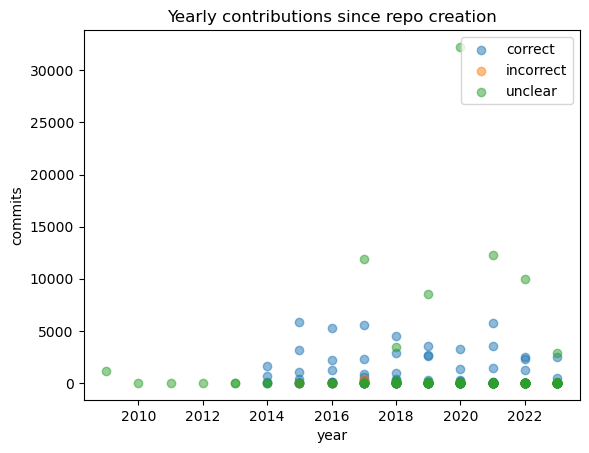

In [40]:
fig, ax = plt.subplots()
for l in labels:
    df = labelled_commits[labelled_commits['link_label'] == l].groupby(['github_repo', 'year'])['commits'].sum().reset_index()
    ax.scatter(df.year, df.commits, label=l, alpha=0.5)
#ax.set_yscale('log')
ax.legend()
ax.set_xlabel('year')
ax.set_ylabel('commits')
ax.set_title('Yearly contributions since repo creation')
plt.show()

#### Histogram of contributions per year

Same data as above, but counting repositories with yearly commits in a certain range. Older repos that are not developed further are included.

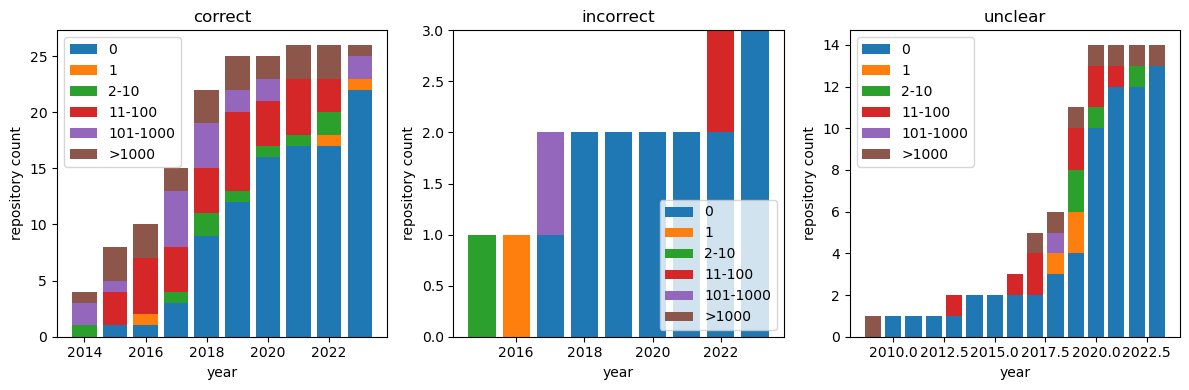

In [41]:
fig, axs = plt.subplots(1, len(labels), figsize=(4*len(labels), 4))
max = 0
bin_labels = ['0', '1', '2-10', '11-100', '101-1000', '>1000']
for l_idx, l in enumerate(labels):
    ax = axs[l_idx]
    df = labelled_commits[labelled_commits['link_label'] == l].groupby(['github_repo', 'year'])['commits'].sum().reset_index()
    max = df.commits.max() if df.commits.max() > max else max
    bins = [0, 1, 2, 10, 100, 1000, max]
    data = []
    for y in df.year:
        counts, _ = np.histogram(df[df['year'] == y].commits, bins)
        data.append(counts)
    data = np.array(data).T
    bottom = 0
    for i in range(len(bin_labels)):
        p = ax.bar(df.year, data[i], label=bin_labels[i], bottom=bottom)
        bottom += data[i]
    ax.legend()
    ax.set_xlabel('year')
    ax.set_ylabel('repository count')
    ax.set_title(l)
fig.tight_layout()
plt.show()

### Contributions since start year

Look at total number of commits, plotted against the start year of repo.

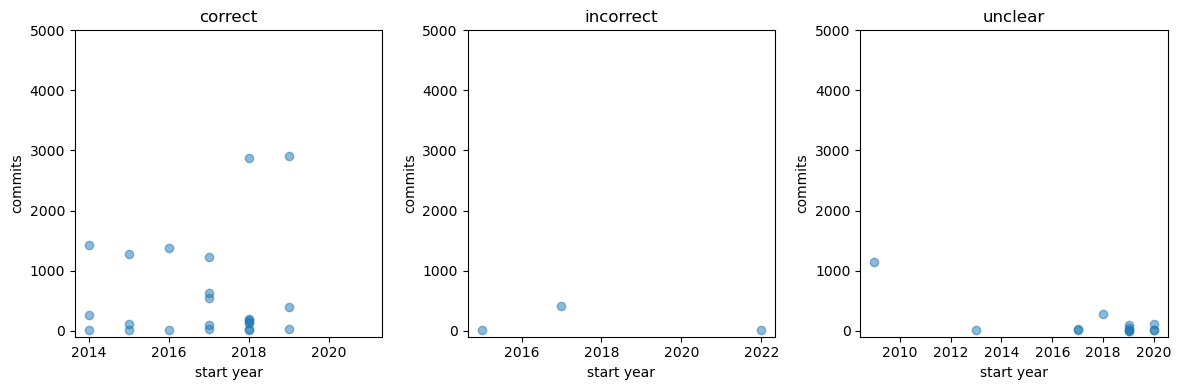

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i, l in enumerate(labels):
    ax = axs[i]
    df = labelled_commits[labelled_commits['link_label'] == l].groupby(['github_repo'])
    ax.scatter(df.year.min(), df.commits.sum(), alpha=0.5)
    ax.set_ylabel('commits')
    ax.set_xlabel('start year')
    ax.set_title(l)
    ax.set_ylim(-100, 5000)
fig.tight_layout()
plt.show()

#### Histogram version

Same data as above.

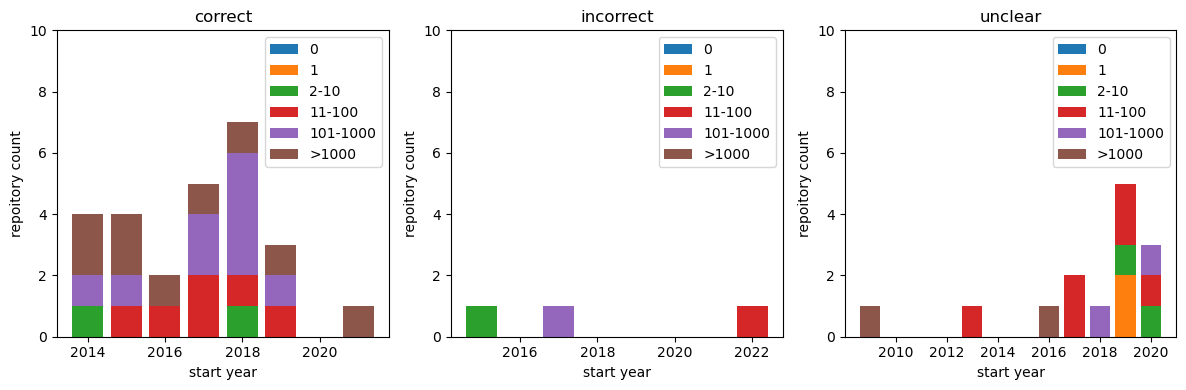

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
bin_labels = ['0', '1', '2-10', '11-100', '101-1000', '>1000']
max = 0
for i, l in enumerate(labels):
    ax = axs[i]
    df = labelled_commits[labelled_commits['link_label'] == l].groupby(['github_repo'])
    df = pd.merge(df.commits.sum().reset_index(), df.year.min().reset_index(), on='github_repo')
    max = df.commits.max() if df.commits.max() > max else max
    bins = [0, 1, 2, 10, 100, 1000, max]
    years = df.year.unique()
    data = []
    for y in years:
        counts, _ = np.histogram(df[df.year == y].commits, bins)
        data.append(counts)
    data = np.array(data).T
    bottom = 0
    for i in range(len(bin_labels)):
        p = ax.bar(years, data[i], label=bin_labels[i], bottom=bottom)
        bottom += data[i]
    ax.legend()
    ax.set_ylabel('repoitory count')
    ax.set_xlabel('start year')
    ax.set_title(l)
    ax.set_ylim(0, 10)
fig.tight_layout()
plt.show()

### Maintenance time

Number of weeks between first and last commit.

In [47]:
def delta_weeks(start_year, start_week, end_year, end_week):
    start = datetime.date.fromisocalendar(start_year, start_week, 1)
    end = datetime.date.fromisocalendar(end_year, end_week, 1)
    return int((end-start).days/7)

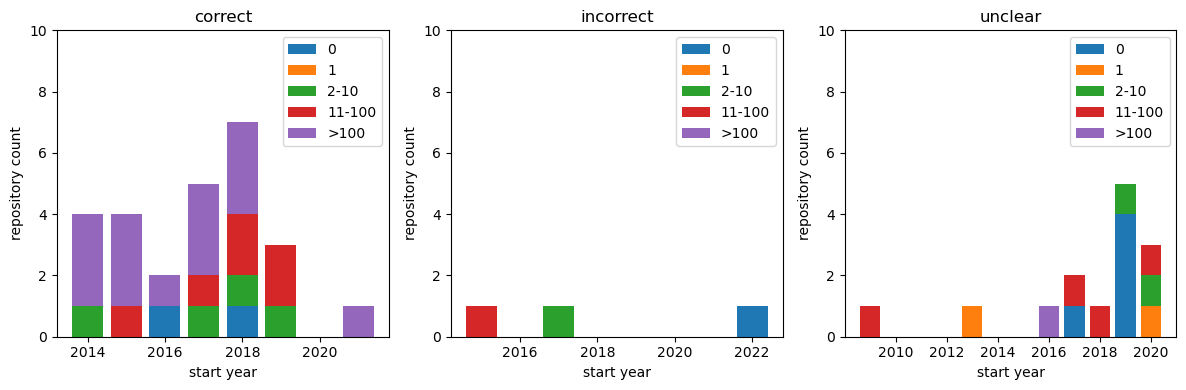

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
bin_labels = ['0', '1', '2-10', '11-100', '>100']
max = 0
for i, l in enumerate(labels):
    ax = axs[i]
    cond_df = labelled_commits[(labelled_commits['link_label'] == l) & (labelled_commits['commits'] > 0)]
    first_week_of_year = cond_df.groupby(['github_repo', 'year']).week.min().reset_index()
    last_week_of_year = cond_df.groupby(['github_repo', 'year']).week.max().reset_index()
    first_year = cond_df.groupby(['github_repo']).year.min().reset_index()
    last_year = cond_df.groupby(['github_repo']).year.max().reset_index()
    df_start = pd.merge(first_year, first_week_of_year)
    df_start.rename(columns={'year': 'start_year', 'week': 'start_week'}, inplace=True)
    df_end = pd.merge(last_year, last_week_of_year)
    df_end.rename(columns={'year': 'end_year', 'week': 'end_week'}, inplace=True)
    df = pd.merge(df_start, df_end, on='github_repo')
    df['contribution_time'] = df.apply(lambda row: delta_weeks(row.start_year, row.start_week, row.end_year, row.end_week), axis=1)
    max = df.contribution_time.max() if df.contribution_time.max() > max else max
    bins = [0, 1, 2, 10, 100, max]
    years = df.start_year.unique()
    data = []
    for y in years:
        counts, _ = np.histogram(df[df.start_year == y].contribution_time, bins)
        data.append(counts)
    data = np.array(data).T
    bottom = 0
    for i in range(len(bin_labels)):
        p = ax.bar(years, data[i], label=bin_labels[i], bottom=bottom)
        bottom += data[i]
    ax.legend()
    ax.set_ylabel('repository count')
    ax.set_xlabel('start year')
    ax.set_title(l)
    ax.set_ylim(0, 10)
fig.tight_layout()
plt.show()

### Team size

Highest number of contributors within a year, plotted against the start year of the repo.

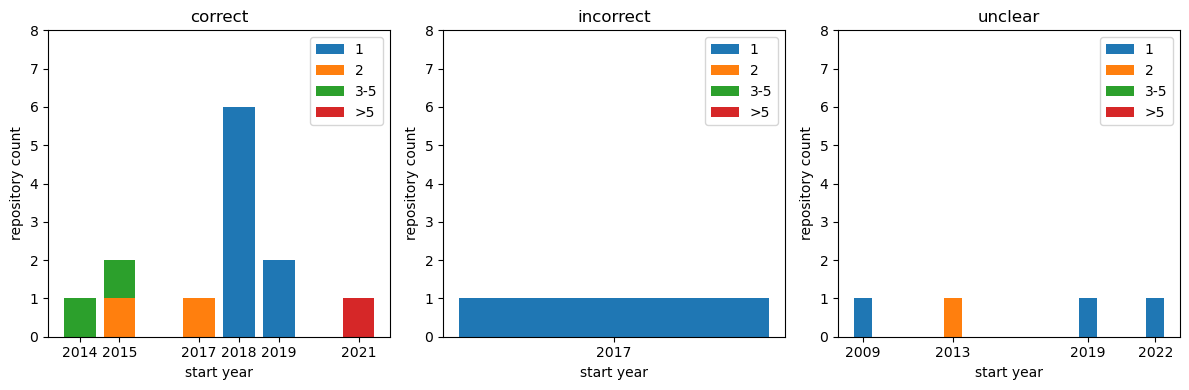

In [49]:
fig, axs = plt.subplots(1, len(labels), figsize=(4*len(labels), 4))
max = 6
bin_labels = ['1', '2', '3-5', '>5']
for l_idx, l in enumerate(labels):
    ax = axs[l_idx]
    df = labelled_commits[(labelled_commits['link_label'] == l) & (contributions_df.commits > 0)].groupby(['github_repo', 'year', 'author']).commits.sum().reset_index()
    authors_per_year_df = df.groupby(['github_repo', 'year']).author.count().reset_index(name='author_count')
    start_year_df = df.groupby(['github_repo']).year.min().reset_index(name='start_year')
    team_size_df = authors_per_year_df.groupby(['github_repo']).author_count.max().reset_index(name='team_size')
    data_df = pd.merge(start_year_df, team_size_df)
    max = data_df.team_size.max() if data_df.team_size.max() > max else max
    bins = [1, 2, 3, 5, max]
    data = []
    for y in data_df.start_year.unique():
        counts, _ = np.histogram(data_df[data_df['start_year'] == y].team_size, bins)
        data.append(counts)
    data = np.array(data).T
    bottom = 0
    for i in range(len(bin_labels)):
        p = ax.bar(data_df.start_year.unique(), data[i], label=bin_labels[i], bottom=bottom)
        bottom += data[i]
    ax.legend()
    ax.set_xlabel('start year')
    ax.set_xticks(data_df.start_year.unique())
    ax.set_ylabel('repository count')
    ax.set_ylim((0, 8))
    ax.set_title(l)
fig.tight_layout()
plt.show()

### Licence

Changes in chosen licence, plotted against the start year of the repo.

In [50]:
contents_df = contents_df.drop_duplicates()

In [51]:
labelled_repos = labelled_commits[['github_repo', 'link_label']].drop_duplicates()
start_year = contributions_df.groupby(['github_repo']).year.min().reset_index()
license_df = pd.merge(contents_df, start_year)
license_df = pd.merge(license_df, labelled_repos)

In [52]:
license_df.license.isna().sum()

30

In [53]:
license_df.fillna({'license': 'none'}, inplace=True)

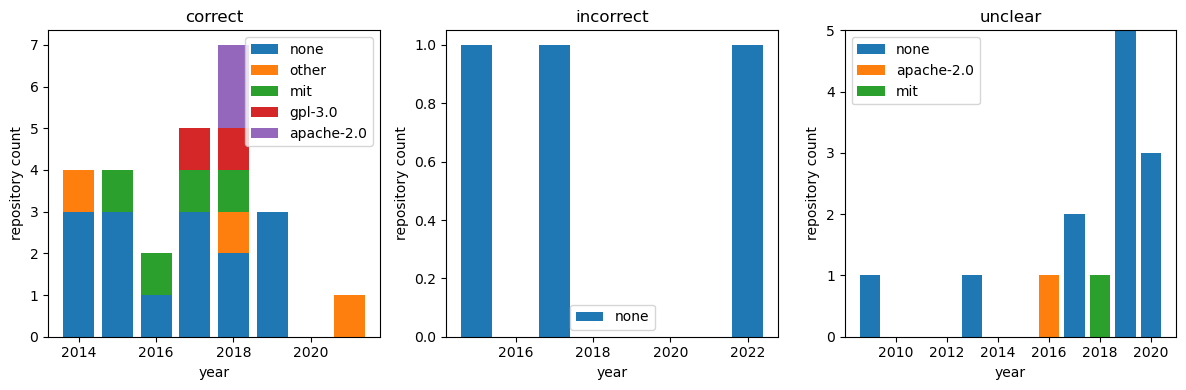

In [54]:
fig, axs = plt.subplots(1, len(labels), figsize=(4*len(labels), 4))
for l_idx, l in enumerate(labels):
    ax = axs[l_idx]
    df = license_df[license_df['link_label'] == l].groupby(['year', 'license']).license.count().reset_index(name='license_count')
    unique_years = df.year.unique()
    bottom = np.zeros(len(unique_years), dtype=np.uint)
    for li in df.license.unique():
        license_type_df = df[df['license'] == li]
        #years = list(df[df['license'] == li].year)
        #counts = list(df[df['license'] == li].license_count)
        for y in (set(unique_years)-set(license_type_df.year)):
            license_type_df = pd.concat([license_type_df, pd.Series({'year': y, 'license': li, 'license_count': 0}).to_frame().T], ignore_index=True)
        license_type_df = license_type_df.sort_values(by=['year'])
        p = ax.bar(license_type_df.year, license_type_df.license_count, label=li, bottom=bottom)
        bottom += license_type_df.license_count.to_numpy(dtype=np.uint)
    ax.legend()
    ax.set_xlabel('year')
    ax.set_ylabel('repository count')
    ax.set_title(l)
fig.tight_layout()
plt.show()